In [1]:
%cd /data/majoroval/jupyter/RS-25/homework/week02

/data/majoroval/jupyter/RS-25/homework/week02


In [2]:
import requests

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from textwrap import wrap
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score, log_loss, ndcg_score
from pprint import pprint

In [3]:
%load_ext autoreload

In [4]:
%autoreload 1
from framework import setup_logging, FeatureFactory, Config, DataLoader, Experiment

In [5]:
setup_logging()

<Logger lavka_recsys (DEBUG)>

# EDA

In [6]:
train = pl.read_parquet('train.parquet')
test = pl.read_parquet('test.parquet')

# Если запускаетесь на кагле:
# train = train.sample(200000, shuffle=True)

train.head(100)

action_type,city_name,position_in_request,product_category,product_id,product_image,product_name,request_id,source_type,store_id,timestamp,user_id
str,str,i64,str,u64,str,str,u64,str,u64,i64,u64
"""AT_View""","""Москва""",36,"""ЛАПША ГРЕЧНЕВАЯ С МЯСОМ""",16123780718943738616,"""https://avatars.mds.yandex.net…","""Гречневая лапша с курицей, ово…",2648890305186553331,"""ST_Feed""",16009534250158248514,1679806419,9812600053596579429
"""AT_View""","""Краснодар""",4,"""Другие соленья""",9225194405337347900,"""https://avatars.mds.yandex.net…","""Грибы Опята маринованные «Гриб…",11772559297474986756,"""ST_Catalog""",17528705347053126993,1684047251,5490055591987012418
"""AT_View""","""Москва""",8,"""Другие виды вафель""",5093205019591406338,"""https://avatars.mds.yandex.net…","""Палочки вафельные «Коломенский…",6530124002700424792,"""ST_Search""",8036341040759991016,1687439633,7732070145991942829
"""AT_View""","""Санкт-Петербург""",6,"""Коласодержащие напитки с сахар…",6248957849722053876,"""https://avatars.mds.yandex.net…","""Напиток Cola «Добрый» газирова…",16719003150245349158,"""ST_OnClickDelivery""",13710539526554605580,1688540033,6666258464011831625
"""AT_View""","""Санкт-Петербург""",4,"""Зерновые чипсы""",1860732219874556850,"""https://avatars.mds.yandex.net…","""Чипсы цельнозерновые Корнерсы …",16169165339671437251,"""ST_Uplift""",12515600471032553786,1678793136,12902623331747310451
…,…,…,…,…,…,…,…,…,…,…,…
"""AT_View""","""Москва""",18,"""Мороженое в ведерках/лотках""",4962457401570396603,"""https://avatars.mds.yandex.net…","""Мороженое Monterra бельгийский…",3732239185086142913,"""ST_Catalog""",2253484422878426321,1687522515,4529653658662005692
"""AT_View""","""Москва""",7,"""СЫРНИКИ С НАЧИНКАМИ И ТОПИНГАМ…",18119989971542602749,"""https://avatars.mds.yandex.net…","""Сырники с вишней «Из Лавки», 1…",9213519401833166504,"""ST_Catalog""",15351512924493625964,1687415630,4376886766801706275
"""AT_Click""","""Москва""",null,"""Прочие замороженные торты""",10397281864504523812,"""https://avatars.mds.yandex.net…","""Торт Графские развалины «Из Ла…",14140071391418017592,"""ST_Search""",17885235751668191113,1697192345,9040343820851285402


In [7]:
def load_poster(row):
    title, poster_url = row[0], row[2]
    try:
        response = requests.get(poster_url, timeout=20)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)), title

    except Exception as e:
        print(f"Error loading poster for '{title}': {e}")
        return None, None

def show_posters(data):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    rows = [row for row in data.iter_rows()]

    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(load_poster, rows))

    for idx, (img, title) in enumerate(results):
        ax = axes[idx//5, idx%5]
        if img and title:
            ax.imshow(img)
            wrapped_title = "\n".join(wrap(title, width=40))
            ax.set_title(wrapped_title)
        else:
            ax.set_title("Image not available", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
pprint(train.columns)
print(train.select('action_type').unique())

['action_type',
 'city_name',
 'position_in_request',
 'product_category',
 'product_id',
 'product_image',
 'product_name',
 'request_id',
 'source_type',
 'store_id',
 'timestamp',
 'user_id']
shape: (4, 1)
┌───────────────┐
│ action_type   │
│ ---           │
│ str           │
╞═══════════════╡
│ AT_View       │
│ AT_Purchase   │
│ AT_Click      │
│ AT_CartUpdate │
└───────────────┘


In [9]:
pprint(test.columns)

['city_name',
 'product_category',
 'product_id',
 'product_image',
 'product_name',
 'request_id',
 'source_type',
 'store_id',
 'timestamp',
 'user_id',
 'index']


In [10]:
ignore_columns = ["timestamp"]
columns_to_check = [col for col in train.columns if col not in ignore_columns]
mask = train.select(columns_to_check).is_duplicated()
train.filter(mask).sort(['user_id', 'request_id', 'product_id'])

action_type,city_name,position_in_request,product_category,product_id,product_image,product_name,request_id,source_type,store_id,timestamp,user_id
str,str,i64,str,u64,str,str,u64,str,u64,i64,u64
"""AT_Purchase""","""Санкт-Петербург""",null,"""Колбаски для жарки из мяса""",4558715414860955099,"""https://avatars.mds.yandex.net…","""Колбаски Нежные Гриль «Слово м…",null,null,710512517402360229,1700887792,2849249366679451
"""AT_Purchase""","""Санкт-Петербург""",null,"""Колбаски для жарки из мяса""",4558715414860955099,"""https://avatars.mds.yandex.net…","""Колбаски Нежные Гриль «Слово м…",null,null,710512517402360229,1700375702,2849249366679451
"""AT_Purchase""","""Санкт-Петербург""",null,"""Макароны Спирали/Fusilli""",8639601936681931772,"""https://avatars.mds.yandex.net…","""Макароны Спирали «Из Лавки» вы…",null,null,710512517402360229,1700571433,2849249366679451
"""AT_Purchase""","""Санкт-Петербург""",null,"""Макароны Спирали/Fusilli""",8639601936681931772,"""https://avatars.mds.yandex.net…","""Макароны Спирали «Из Лавки» вы…",null,null,710512517402360229,1700634633,2849249366679451
"""AT_View""","""Санкт-Петербург""",8,"""Корнишоны консервированные""",3261190235265165862,"""https://avatars.mds.yandex.net…","""Огурцы корнишоны «6 соток» мед…",76304872212921154,"""ST_Search""",710512517402360229,1700887041,2849249366679451
…,…,…,…,…,…,…,…,…,…,…,…
"""AT_View""","""Краснодар""",6,"""Сендвич с печеньем""",13605707709880008350,"""https://avatars.mds.yandex.net…","""Мороженое сливочное Maxiduo со…",16750335446144105126,"""ST_Upsale""",7766887739199347268,1703177552,18436895732283272638
"""AT_View""","""Краснодар""",1,"""Чипсы картофельные""",14778430636159791453,"""https://avatars.mds.yandex.net…","""Чипсы Lay's красная икра, 120 …",16750335446144105126,"""ST_Upsale""",7766887739199347268,1703177564,18436895732283272638
"""AT_View""","""Краснодар""",1,"""Чипсы картофельные""",14778430636159791453,"""https://avatars.mds.yandex.net…","""Чипсы Lay's красная икра, 120 …",16750335446144105126,"""ST_Upsale""",7766887739199347268,1703177546,18436895732283272638


In [11]:
n_duplicated = train.filter(mask).sort(['user_id', 'request_id', 'product_id']).height
print(f"{n_duplicated} duplicated actions ({n_duplicated / train.height * 100:.2f}%)")

2831764 duplicated actions (18.94%)


In [18]:
train.select([
    pl.col(col).is_null().sum().alias(col)
    for col in train.columns
])

action_type,city_name,position_in_request,product_category,product_id,product_image,product_name,request_id,source_type,store_id,timestamp,user_id
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,364961,0,0,0,0,207484,197220,0,0,0


In [37]:
def is_one_to_many(df: pl.DataFrame, a: str, b: str) -> bool:
    return df.filter(
        pl.col(a).is_not_null()
    ).group_by(a).agg(
        pl.col(b).n_unique()
    ).select(
        (pl.col(b) > 1).any()
    ).item()

In [32]:
assert not is_one_to_many(train, "request_id", "user_id")

In [29]:
train.group_by("request_id").agg(
    pl.col('user_id').n_unique().alias('unique_users')
).filter(
    pl.col('unique_users') > 1
)

request_id,unique_users
u64,u32
null,1817


In [38]:
is_one_to_many(train, "product_id", "request_id")

True

In [ ]:
train.filter(
    pl.len().over(["product_id", "request_id"]) > 1
).sort(["product_id", "request_id", "timestamp"])

action_type,city_name,position_in_request,product_category,product_id,product_image,product_name,request_id,source_type,store_id,timestamp,user_id
str,str,i64,str,u64,str,str,u64,str,u64,i64,u64
"""AT_Click""","""Москва""",null,"""Творог традиционный 5% жирност…",135314760031236,"""https://avatars.mds.yandex.net…","""Творог 5% «Из молока нашей дой…",527712233664642067,"""ST_Search""",8614843407808375820,1703867347,4854309425845417881
"""AT_Click""","""Москва""",9,"""Творог традиционный 5% жирност…",135314760031236,"""https://avatars.mds.yandex.net…","""Творог 5% «Из молока нашей дой…",527712233664642067,"""ST_Search""",8614843407808375820,1703867347,4854309425845417881
"""AT_View""","""Москва""",43,"""Творог традиционный 5% жирност…",135314760031236,"""https://avatars.mds.yandex.net…","""Творог 5% «Из молока нашей дой…",3300444556544630945,"""ST_Catalog""",16614881320072451264,1702172235,15237384623602312348
"""AT_View""","""Москва""",43,"""Творог традиционный 5% жирност…",135314760031236,"""https://avatars.mds.yandex.net…","""Творог 5% «Из молока нашей дой…",3300444556544630945,"""ST_Catalog""",16614881320072451264,1702173344,15237384623602312348
"""AT_View""","""Москва""",43,"""Творог традиционный 5% жирност…",135314760031236,"""https://avatars.mds.yandex.net…","""Творог 5% «Из молока нашей дой…",3300444556544630945,"""ST_Catalog""",16614881320072451264,1702176125,15237384623602312348
…,…,…,…,…,…,…,…,…,…,…,…
"""AT_View""","""Москва""",6,"""Прочие замороженные десерты""",18445492888512500135,"""https://avatars.mds.yandex.net…","""Малина в белом и тёмном шокола…",15282657303280184209,"""ST_Search""",2890832613819707489,1703245392,12853260265563691565
"""AT_View""","""Москва""",6,"""Прочие замороженные десерты""",18445492888512500135,"""https://avatars.mds.yandex.net…","""Малина в белом и тёмном шокола…",15282657303280184209,"""ST_Search""",2890832613819707489,1703245604,12853260265563691565
"""AT_Click""","""Москва""",null,"""Прочие замороженные десерты""",18445492888512500135,"""https://avatars.mds.yandex.net…","""Малина в белом и тёмном шокола…",18212861830498347190,"""ST_Feed""",10937217160202748432,1703491030,15086836877538964297


In [48]:
train.filter(pl.len().over(["product_id", "request_id"]) > 1).height

4337284

In [50]:
df = train.group_by('product_id', 'request_id').agg(
    pl.len().alias('n_repeats'),
    pl.col('action_type').unique().alias('actions'),
    pl.col('action_type').n_unique().alias('n_actions')
)

In [55]:
(df.select('n_actions') > 1).sum()

n_actions
u32
308394


In [ ]:
train.group_by("user_id").agg(
    pl.col("action_type").n_unique().alias("n_action_types"),
    pl.col("action_type").unique().alias("actions_done")
).filter(
    pl.col("n_action_types") == 1
).filter(
    pl.col('actions_done').list.first() != "AT_View"
)


user_id,n_action_types,actions_done
u64,u32,list[str]
9770717789382945673,1,"[""AT_Click""]"
7867759778367907975,1,"[""AT_Click""]"
15176428480308538604,1,"[""AT_Click""]"
749017433757609826,1,"[""AT_Purchase""]"
17780053322593868644,1,"[""AT_Click""]"
6098988111690241491,1,"[""AT_Purchase""]"
10590700296592113932,1,"[""AT_CartUpdate""]"


In [48]:
train.with_columns(
    (pl.col("timestamp") * 1_000).cast(pl.Datetime("ms")).alias("ts_datetime")
).select([
    pl.col("ts_datetime").min().dt.strftime("%Y-%m-%d %H:%M:%S").alias("earliest"),
    pl.col("ts_datetime").max().dt.strftime("%Y-%m-%d %H:%M:%S").alias("latest")
])

earliest,latest
str,str
"""2022-12-31 18:46:42""","""2023-12-31 20:53:44"""


In [63]:
test.with_columns(
    (pl.col("timestamp") * 1_000).cast(pl.Datetime("ms")).alias("ts_datetime")
).select([
    pl.col("ts_datetime").min().dt.strftime("%Y-%m-%d %H:%M:%S").alias("earliest"),
    pl.col("ts_datetime").max().dt.strftime("%Y-%m-%d %H:%M:%S").alias("latest")
])

earliest,latest
str,str
"""2024-01-01 23:06:24""","""2024-02-02 16:58:16"""


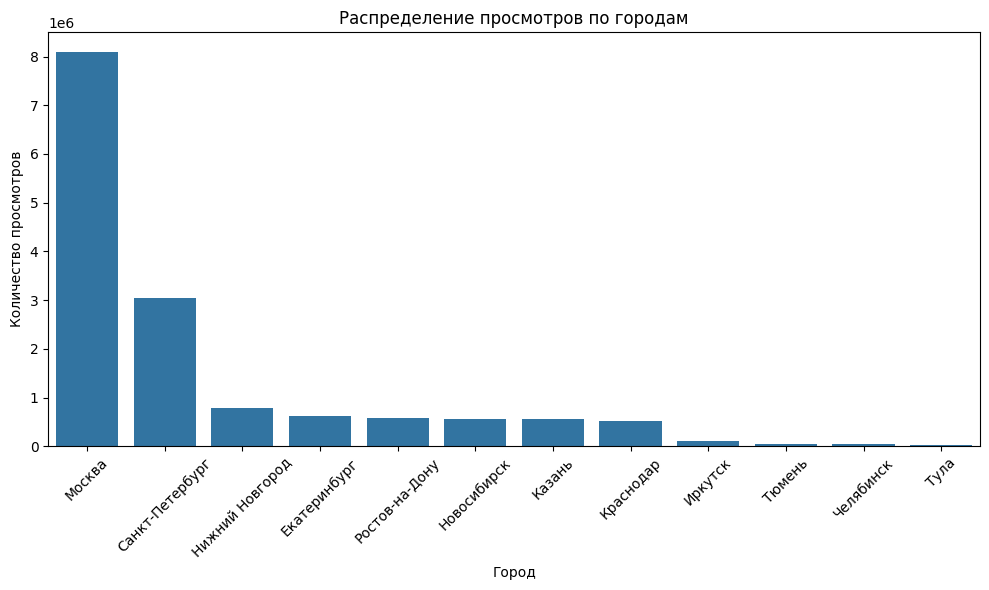

In [49]:
city_analysis = train.group_by("city_name").agg(
    pl.len().alias("actions_count")
).sort("actions_count", descending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="city_name",
    y="actions_count",
    data=city_analysis.to_pandas()
)
plt.title("Распределение просмотров по городам")
plt.xlabel("Город")
plt.ylabel("Количество просмотров")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

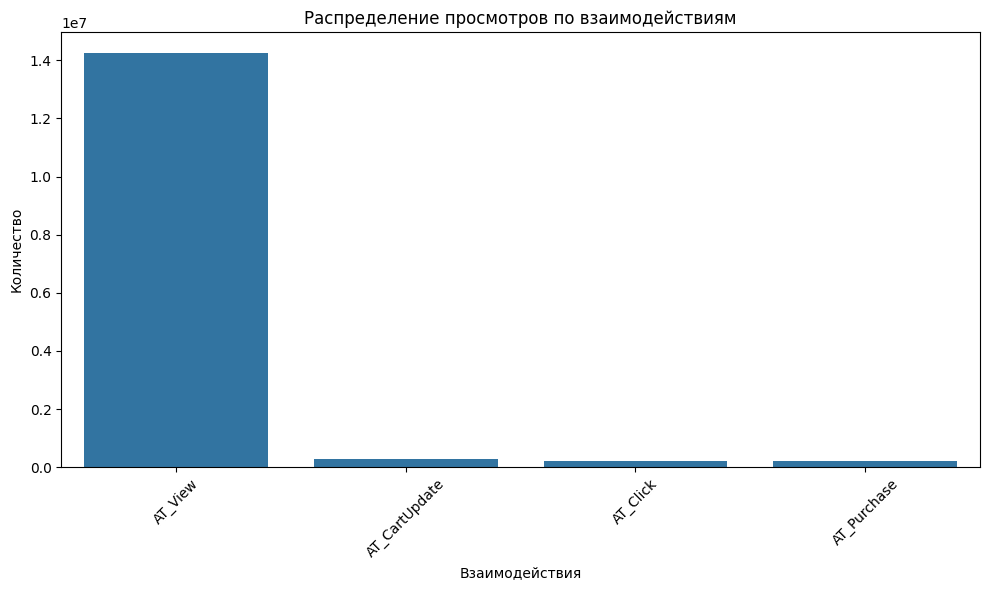

In [50]:
city_analysis = train.group_by("action_type").agg(
    pl.len().alias("actions_count")
).sort("actions_count", descending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="action_type",
    y="actions_count",
    data=city_analysis.to_pandas()
)
plt.title("Распределение просмотров по взаимодействиям")
plt.xlabel("Взаимодействия")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
top_10 = train.filter(
    pl.col('action_type') == 'AT_Purchase'
).group_by(
    'product_name'
).agg(
    pl.len().alias("total_purchase"),
    pl.col('product_image').first()
).sort(
    'total_purchase', descending=True
).head(10)

top_10

product_name,total_purchase,product_image
str,u32,str
"""Майка-пакет с логотипом «Яндек…",10914,"""https://avatars.mds.yandex.net…"
"""Майка-пакет с логотипом Яндекс…",1786,"""https://avatars.mds.yandex.net…"
"""Джиббитса «Зверский детектив»,…",1051,"""https://avatars.mds.yandex.net…"
"""Спелый банан, 1 шт.""",521,"""https://avatars.mds.yandex.net…"
"""Энергетический напиток Adrenal…",488,"""https://avatars.mds.yandex.net…"
"""Батон Нарезной «Черёмушки» в н…",459,"""https://avatars.mds.yandex.net…"
"""Молоко 2,5% «Простоквашино» па…",439,"""https://avatars.mds.yandex.net…"
"""Зелёный банан, 1 шт.""",378,"""https://avatars.mds.yandex.net…"
"""Пирожное бисквитное Kinder Мол…",365,"""https://avatars.mds.yandex.net…"


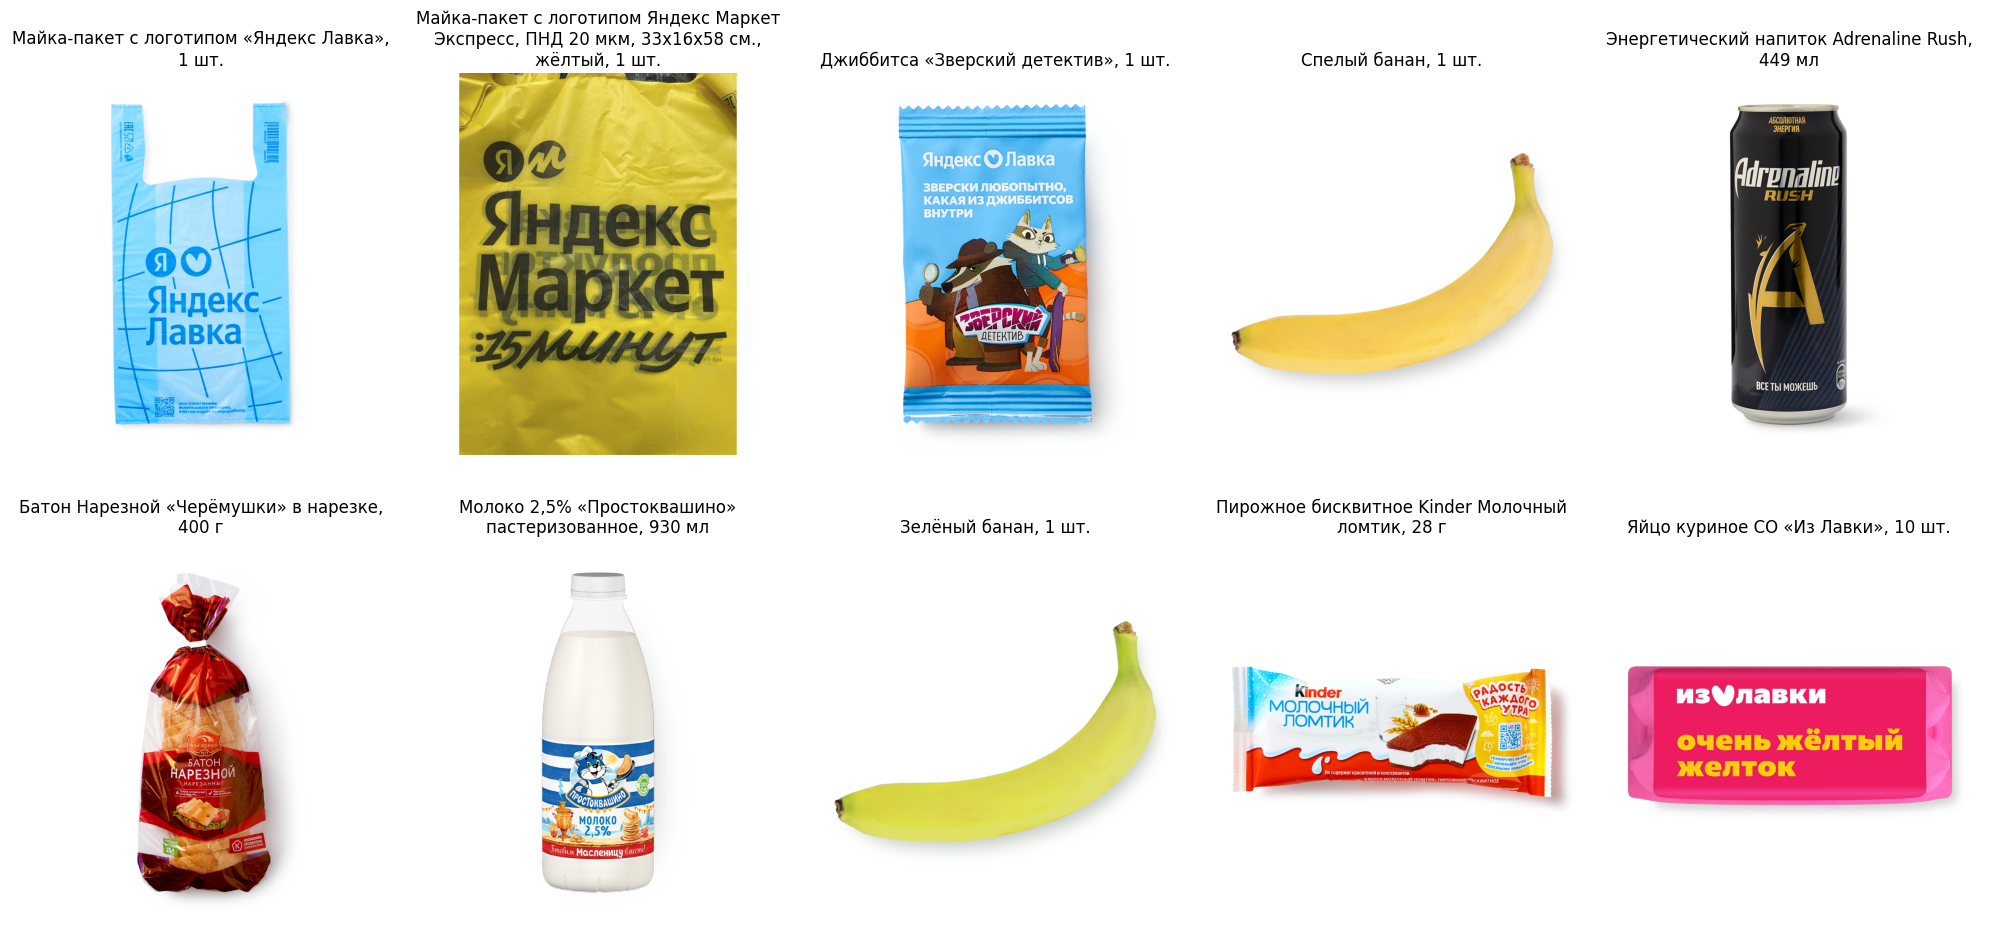

In [52]:
show_posters(top_10)

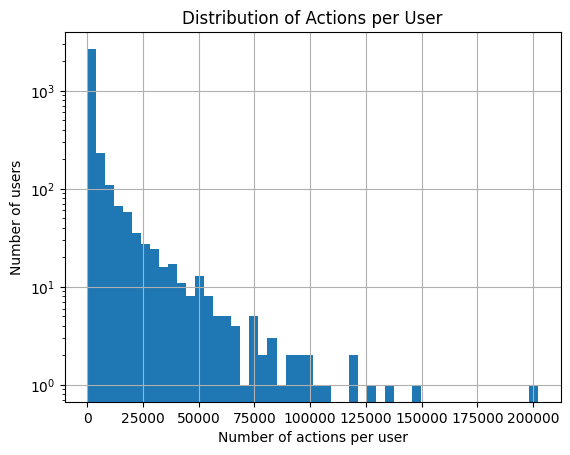

In [55]:
user_action_counts = train.group_by("user_id").len()
counts = user_action_counts["len"].to_pandas()

plt.hist(counts, bins=50)
plt.xlabel("Number of actions per user")
plt.ylabel("Number of users")
plt.title("Distribution of Actions per User")
plt.grid(True)
plt.yscale('log')
plt.show()

In [61]:
nusers_only_viewed = train.group_by("user_id").agg(
    pl.col("action_type").n_unique().alias("n_action_types"),
    pl.col("action_type").unique().alias("actions_done")
).filter(
    pl.col("n_action_types") == 1
).filter(
    pl.col('actions_done').list.first() == "AT_View"
).height

print(f"{nusers_only_viewed} users ({nusers_only_viewed / train['user_id'].n_unique() * 100:.2f}%) only viewed")

909 users (27.42%) only viewed


# Features

In [ ]:
@FeatureFactory.register('count_purchase')
def generate_count_purchase(history_df, target_df):
    """Count purchases by user-product pairs"""
    return history_df.filter(
        pl.col('action_type') == "AT_Purchase"
    ).group_by(
        'user_id', 'product_id'
    ).agg(
        pl.len().alias('count_purchase')
    ).join(
        target_df,
        on=['user_id', 'product_id'],
        how='right'
    )

In [ ]:
@FeatureFactory.register('ctr')
def generate_ctr(history_df, target_df):
    """Calculate CTR (Click-Through Rate) for products"""
    actions = history_df.group_by(
        'action_type', 'product_id'
    ).agg(
        pl.len()
    )
    
    clicks = actions.filter(pl.col('action_type') == "AT_Click")
    views = actions.filter(pl.col('action_type') == "AT_View")
    
    feature = clicks.join(
        views, on='product_id'
    ).with_columns(
        ctr=pl.col('len') / pl.col('len_right')
    ).select(
        'product_id', 'ctr'
    )
    return target_df.join(
        feature,
        on=['target_id'],
        how='left'
    )

In [ ]:
@FeatureFactory.register_target('CartUpdate_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame):
    mapping = {
        'AT_View': 0,
        'AT_Click': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

In [40]:
config = Config()

In [41]:
ff = FeatureFactory(config)
dl = DataLoader(config)

In [42]:
dl.load_data()
splits = dl.create_validation_splits()

2025-04-12 05:29:29,439 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-12 05:29:29,443 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 05:29:29,445 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-12 05:29:29,447 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 05:29:31,033 - lavka_recsys.DataLoader - INFO - Created 1 temporal validation folds


In [43]:
len(splits)

1

In [44]:
(train_history, train_df, val_df) = splits[0]

In [45]:
train_features, train_target = ff.generate_batch(
    train_history, train_df, ["count_purchase", 'ctr'], 'CartUpdate_vs_View'
)

2025-04-12 05:29:31,353 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase, ctr
4728558


In [46]:
train_features.head()

count_purchase,ctr
u32,f64
null,0.004124
null,0.008475
null,0.009689
null,0.014815
null,0.007485


In [47]:
train_features.select(pl.col('count_purchase').is_null().any())

count_purchase
bool
true


In [48]:
train_features.height, train_target.len()

(4574557, 4574557)

In [49]:
config = Config()
exp = Experiment("test", config)
exp.run()

2025-04-12 05:29:37,896 - lavka_recsys.experiment=test - INFO - Saved experiment configuration to results/test_cbbd10_config.json
2025-04-12 05:29:37,900 - lavka_recsys.experiment=test - INFO - Starting experiment: test_cbbd10
2025-04-12 05:29:37,901 - lavka_recsys.experiment=test - INFO - Feature names: ['count_purchase', 'ctr']
2025-04-12 05:29:37,902 - lavka_recsys.experiment=test - INFO - Model type: catboost


2025-04-12 05:29:38,176 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-12 05:29:38,179 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 05:29:38,181 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-12 05:29:38,183 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 05:29:39,797 - lavka_recsys.DataLoader - INFO - Created 1 temporal validation folds


cv:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-12 05:29:39,812 - lavka_recsys.experiment=test - INFO - Processing fold 1/1
2025-04-12 05:29:39,813 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase, ctr
4728558
2025-04-12 05:29:41,341 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase, ctr
5897980
0:	test: 0.5760922	best: 0.5760922 (0)	total: 444ms	remaining: 2m 12s
1:	test: 0.5907315	best: 0.5907315 (1)	total: 822ms	remaining: 2m 2s
2:	test: 0.5899485	best: 0.5907315 (1)	total: 1.15s	remaining: 1m 54s
3:	test: 0.5893190	best: 0.5907315 (1)	total: 1.5s	remaining: 1m 50s
4:	test: 0.5893181	best: 0.5907315 (1)	total: 1.85s	remaining: 1m 48s
5:	test: 0.5895498	best: 0.5907315 (1)	total: 2.17s	remaining: 1m 46s
6:	test: 0.5898756	best: 0.5907315 (1)	total: 2.5s	remaining: 1m 44s
7:	test: 0.5902546	best: 0.5907315 (1)	total: 2.84s	remaining: 1m 43s
8:	test: 0.5919820	best: 0.5919820 (8)	total: 3.19s	remaining: 1m 43s
9:	test: 0.5867113	best: 0.5919820 (8)	total: 3.52s	remaining: 1m

{'name': 'test_cbbd10',
 'feature_names': ['count_purchase', 'ctr'],
 'model_type': 'catboost',
 'cv_results': {'folds': [{'fold': 0,
    'metrics': {'auc': 0.6064904879306604,
     'logloss': 0.08149670055462947,
     'ndcg@10': 0.02522935779816514},
    'feature_importance': {'count_purchase': 1.9908692977868456,
     'ctr': 98.00913070221316}}],
  'average_metrics': {'auc': 0.6064904879306604,
   'logloss': 0.08149670055462947,
   'ndcg@10': 0.02522935779816514}},
 'test_predictions': None,
 'runtime': 117.22683787345886}